In [24]:
from audio_classification.preprocess import preprocess

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import os
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, Dense, add, MaxPool2D, Dropout, GlobalMaxPool2D

In [2]:
NUMBER_OF_MFCCS = 13
CLIP_SIZE = 1290
SAMPLE_SHAPE = (NUMBER_OF_MFCCS, CLIP_SIZE, 1)

MODEL_FOLDER = os.path.join('models', 'siamese')
MODEL_PATH = os.path.join(MODEL_FOLDER, 'model.h5')
KNN_SAMPLES_PATH = os.path.join(MODEL_FOLDER, 'data.npy')
KNN_LABELS_PATH = os.path.join(MODEL_FOLDER, 'labels.npy')

if not os.path.isdir(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)

In [3]:
data, similarity = preprocess(NUMBER_OF_MFCCS)

le = preprocessing.LabelEncoder()
transformed = le.fit_transform(data['label'])
l = []
for index, row in data.iterrows():
    arr = np.load(row['file'])
    l.append(arr[:, :CLIP_SIZE])
    
X = np.expand_dims(np.stack(l), axis=3)
y = np.array(transformed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=666)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, random_state=666)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

Cached features found


In [4]:
if not os.path.isdir(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)

class CustomMetricCallback(keras.callbacks.Callback):
    def __init__(self, patience, verbose = 0, save_best = True):
        super(keras.callbacks.Callback, self).__init__()
        self.patience = patience
        self.verbose = verbose
        self.save_best = save_best
        self.best_val_score = -float('inf')
        self.last_improvement = 0


    def on_epoch_end(self, epoch, logs={}):
        train_features = np.asarray(self.model.predict(train_dataset))
        valid_features = np.asarray(self.model.predict(valid_dataset))
        
        knn = KNeighborsClassifier(n_neighbors=12)
        knn.fit(train_features, y_train)
        
        train_pred = knn.predict(train_features)
        valid_pred = knn.predict(valid_features)
        
        train_score = accuracy_score(y_train, train_pred)
        valid_score = accuracy_score(y_valid, valid_pred)
        
        if self.verbose > 0:
            print(f', acc: {train_score}, val_acc: {valid_score}')
            
        if self.save_best and self.best_val_score < valid_score:
            print(f'Best improved: {self.best_val_score} -> {valid_score}. Saving model to {MODEL_FOLDER}')
            self.best_val_score = valid_score
            self.last_improvement = epoch
            self.model.save(MODEL_PATH, overwrite=True)
            
            np.save(KNN_SAMPLES_PATH, train_features)
            np.save(KNN_LABELS_PATH, y_train)
        else:
            print(f'Score did not improve')
            
        if self.patience is not None and epoch - self.last_improvement > self.patience:
            print(f'Score did not improve for {self.patience} epochs. Stopping')
            self.model.stop_training = True

In [5]:
def res_block_2l(block_number, input_block, filters, strides = 1):
    block_name = 'block' + str(block_number) + '_'

    y = Conv2D(
        filters=filters,
        kernel_size=3,
        strides=strides, 
        padding='same', 
        name=block_name + 'conv_1'
    )(input_block)
    y = BatchNormalization(name=block_name + 'bn_1')(y)
    y = Activation('relu', name=block_name + 'activation_1')(y)

    y = Conv2D(
        filters=filters, 
        kernel_size=3, 
        padding='same',
        name=block_name + 'conv_2'
    )(y)
    y = BatchNormalization(name=block_name + 'bn_2')(y)

    if strides != 1:
        z = Conv2D(kernel_size=1, filters=filters, strides=strides, name=block_name + 'conv_S')(input_block)
        z = BatchNormalization(name=block_name + 'bn_S')(z)
    else:
        z = input_block
    x = add([z, y], name=block_name + 'add')
    return Activation('relu', name=block_name + 'activation_after')(x)


inp = Input(shape=SAMPLE_SHAPE, name='embedding_input')

x = Conv2D(filters=32, kernel_size=3, padding='same', name='conv_first')(inp)
x = BatchNormalization(name='bn_first')(x)
x = Activation('relu')(x)

x = res_block_2l(1, x, 32)
x = res_block_2l(2, x, 64, 2)
x = res_block_2l(3, x, 64)
x = res_block_2l(4, x, 64)
x = res_block_2l(5, x, 128, 2)
x = res_block_2l(6, x, 128)

x = GlobalMaxPool2D()(x)

x = Dense(128, name='dense_1', activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, name='dense_2')(x)

model = Model(inp, x, name='embedding_model')

model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss=tfa.losses.TripletSemiHardLoss()
)
#model.summary()

In [6]:
tf.config.run_functions_eagerly(True)
history = model.fit(
    train_dataset,
    epochs=1000,
    callbacks=[CustomMetricCallback(patience=20, verbose=1)]
)

Epoch 1/1000
19/19 [==============================] - ETA: 0s - loss: 0.3694, acc: 0.51, val_acc: 0.37
Best improved: -inf -> 0.37. Saving model to models/siamese
19/19 [==============================] - 16s 854ms/step - loss: 0.3694
Epoch 2/1000
19/19 [==============================] - ETA: 0s - loss: 0.2748, acc: 0.43666666666666665, val_acc: 0.275
Score did not improve
19/19 [==============================] - 15s 776ms/step - loss: 0.2748
Epoch 3/1000
19/19 [==============================] - ETA: 0s - loss: 0.2405, acc: 0.49833333333333335, val_acc: 0.37
Score did not improve
19/19 [==============================] - 15s 779ms/step - loss: 0.2405
Epoch 4/1000
19/19 [==============================] - ETA: 0s - loss: 0.1568, acc: 0.49833333333333335, val_acc: 0.355
Score did not improve
19/19 [==============================] - 15s 776ms/step - loss: 0.1568
Epoch 5/1000
19/19 [==============================] - ETA: 0s - loss: 0.1772, acc: 0.59, val_acc: 0.455
Best improved: 0.37 -> 0.45

Epoch 39/1000
19/19 [==============================] - ETA: 0s - loss: 0.0169, acc: 0.8516666666666667, val_acc: 0.575
Score did not improve
19/19 [==============================] - 13s 705ms/step - loss: 0.0169
Epoch 40/1000
19/19 [==============================] - ETA: 0s - loss: 0.0153, acc: 0.8583333333333333, val_acc: 0.605
Score did not improve
19/19 [==============================] - 13s 706ms/step - loss: 0.0153
Epoch 41/1000
19/19 [==============================] - ETA: 0s - loss: 0.0134, acc: 0.8433333333333334, val_acc: 0.57
Score did not improve
19/19 [==============================] - 13s 704ms/step - loss: 0.0134
Epoch 42/1000
19/19 [==============================] - ETA: 0s - loss: 0.0117, acc: 0.84, val_acc: 0.6
Score did not improve
19/19 [==============================] - 13s 703ms/step - loss: 0.0117
Epoch 43/1000
19/19 [==============================] - ETA: 0s - loss: 0.0154, acc: 0.8533333333333334, val_acc: 0.595
Score did not improve
19/19 [=====================

Epoch 78/1000
19/19 [==============================] - ETA: 0s - loss: 0.0155, acc: 0.895, val_acc: 0.61
Score did not improve
19/19 [==============================] - 16s 862ms/step - loss: 0.0155
Epoch 79/1000
19/19 [==============================] - ETA: 0s - loss: 0.0144, acc: 0.89, val_acc: 0.615
Score did not improve
19/19 [==============================] - 17s 900ms/step - loss: 0.0144
Epoch 80/1000
19/19 [==============================] - ETA: 0s - loss: 0.0088, acc: 0.8583333333333333, val_acc: 0.61
Score did not improve
Score did not improve for 20 epochs. Stopping
19/19 [==============================] - 17s 899ms/step - loss: 0.0088


In [11]:
from sklearn.neighbors import KNeighborsClassifier

model = tf.keras.models.load_model(MODEL_PATH, compile=False)

train_features = model.predict(train_dataset)

knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(train_features, y_train)

train_predictions = knn.predict(train_features)

test_features = model.predict(test_dataset)
test_predictions = knn.predict(test_features)

=== TRAIN ===
              precision    recall  f1-score   support

       blues       0.77      0.92      0.84        60
   classical       0.98      1.00      0.99        60
     country       0.77      0.85      0.81        60
       disco       0.78      0.85      0.82        60
      hiphop       0.77      0.77      0.77        60
        jazz       0.92      0.95      0.93        60
       metal       0.89      0.98      0.94        60
         pop       0.93      0.83      0.88        60
      reggae       0.79      0.70      0.74        60
        rock       0.81      0.57      0.67        60

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600

=== TEST ===
              precision    recall  f1-score   support

       blues       0.71      0.75      0.73        20
   classical       0.94      0.85      0.89        20
     country       0.52      0.70      0.60        

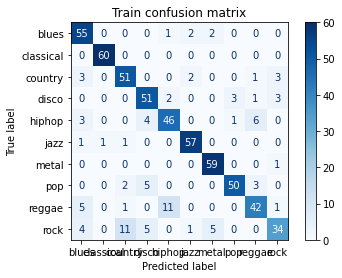

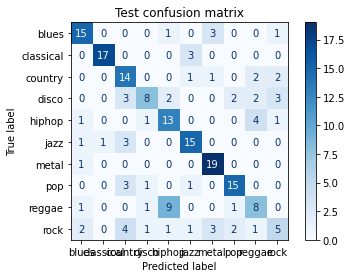

In [12]:
from sklearn.metrics import classification_report, plot_confusion_matrix
print('=== TRAIN ===')
print(classification_report(y_train, train_predictions, target_names=le.classes_))
disp = plot_confusion_matrix(knn, train_features, y_train,
                             display_labels=le.classes_,
                             cmap=plt.cm.Blues)
disp.ax_.set_title('Train confusion matrix');

print('=== TEST ===')
print(classification_report(y_test, test_predictions, target_names=le.classes_))
disp = plot_confusion_matrix(knn, test_features, y_test,
                             display_labels=le.classes_,
                             cmap=plt.cm.Blues)
disp.ax_.set_title('Test confusion matrix');

In [13]:
fit = umap.UMAP()
u = fit.fit_transform(train_features)

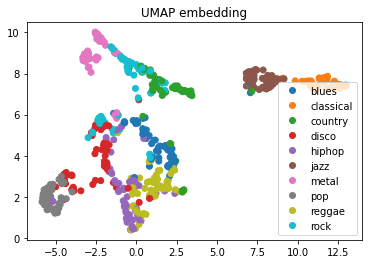

In [30]:
scatter = plt.scatter(u[:,0], u[:,1], c=y_train, cmap='tab10')
plt.title('UMAP embedding')
handles, labels = scatter.legend_elements()

plt.legend(handles, le.classes_);